In [1]:

%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import math
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from qolmat.diffusion_model  import ImputerDiffusion
from qolmat.model  import TabDDPM, TsDDPM
from diffusion import DDPM
from load_data import prepare_data, aggregate_market_data
from models import CustomTransformerTimeSeries
from dataloader import TimeSeriesDataset
from models import AutoEncoder, ResidualBlockTS
import joblib
import random

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
START_TRAIN = "1999"
END_TRAIN = "2021"
START_TEST = "2022"
SCALER = 'QT'
data = aggregate_market_data()
df_reindexed, df_orig, df = prepare_data(data, from_year = START_TRAIN,
                                         start_year_test = START_TEST,
                                         scaler = SCALER)
train_df = df_reindexed.loc[:END_TRAIN]
train_df = train_df.interpolate(method='nearest')
X_train = train_df.to_numpy()
X_train = torch.tensor(X_train, dtype=torch.float32, device=DEVICE)
df_orig = df_orig['Ret'].unstack().T

100%|██████████| 142/142 [01:20<00:00,  1.76it/s]


failed long_forecasting


c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (100) is greater than the total number of samples (53). n_quantiles is set to n_samples.
  warnings.warn(


In [7]:
SCALER = 'standardscaler'
sc_loaded = joblib.load('results/'+SCALER+'.save')
original_data = pd.DataFrame(sc_loaded.inverse_transform(df_orig.T).T,columns = df_orig.columns, index = df_orig.index)
original_data
N_OBS = original_data.shape[0]
N_OBS

6163

In [8]:
import random

In [9]:
def sample_sequence(df,n_rows,sequence_size):
    out = []
    completed = 0
    while n_rows - completed > sequence_size:
        nrows = range(df.shape[0])
        ix = random.randint(nrows.start, nrows.stop-5)
        sample = df.iloc[ix:ix+sequence_size, :]
        completed+=sequence_size
        df.drop(sample.index,axis=0,inplace=True)
        out.append(sample)
        
    last_sample = df.sample(n_rows - completed)
    out.append(last_sample)
    new_df = pd.concat(out,axis=0)
    return new_df

In [10]:
def get_synth_data(original_data:pd.DataFrame,scaler,parameter:str = 'SEQ_LEN',parameter_value:int =21):
    N_OBS = original_data.shape[0]
    path = os.path.join(os.getcwd(),'results','DDPM',parameter,str(parameter_value))
    path_samples = os.path.join(path,'samples.npy')
    samples = np.load(path_samples)
    print(samples.shape)
    selected_samples = samples
    reshaped_samples = selected_samples.reshape(-1, selected_samples.shape[-1])
    synth_data = pd.DataFrame(reshaped_samples)
    seq_len = parameter_value if parameter =='SEQ_LEN' else 21
    synth_data = sample_sequence(synth_data,N_OBS,seq_len)
    
    synth_data_rescaled = pd.DataFrame(scaler.inverse_transform(synth_data.T).T,columns = original_data.columns,
                                    index = original_data.index)
    return synth_data_rescaled

synth_5= get_synth_data(original_data= original_data,scaler=sc_loaded,parameter = 'SEQ_LEN',parameter_value =5)
synth_10= get_synth_data(original_data= original_data,scaler=sc_loaded,parameter = 'SEQ_LEN',parameter_value =10)
synth_21= get_synth_data(original_data= original_data,scaler=sc_loaded,parameter = 'SEQ_LEN',parameter_value =21)
synth_63= get_synth_data(original_data= original_data,scaler=sc_loaded,parameter = 'SEQ_LEN',parameter_value =63)
synth_126= get_synth_data(original_data= original_data,scaler=sc_loaded,parameter = 'SEQ_LEN',parameter_value =126)
synth_252= get_synth_data(original_data= original_data,scaler=sc_loaded,parameter = 'SEQ_LEN',parameter_value =252)


(1500, 5, 53)
(1500, 10, 53)
(1500, 21, 53)
(1500, 63, 53)
(1500, 126, 53)
(1500, 252, 53)


In [16]:
cmpr = pd.concat([synth_5.stack(),
            synth_10.stack(),
            synth_21.stack(),
            synth_63.stack(),
            synth_126.stack(),
            synth_252.stack(),
            original_data.stack()],axis=1,keys = [5,10,21,63,126,252,'original'])

cmpr = pd.concat([
            synth_252.stack(),
            original_data.stack()],axis=1,keys = ['synthetic','original'])

# cmpr = pd.concat([synth_1.stack(),
#             synth_2.stack(),
#             synth_4.stack(),
#             synth_8.stack(),
#             original_data.stack()],axis=1,keys = [1,2,4,8,'original'])



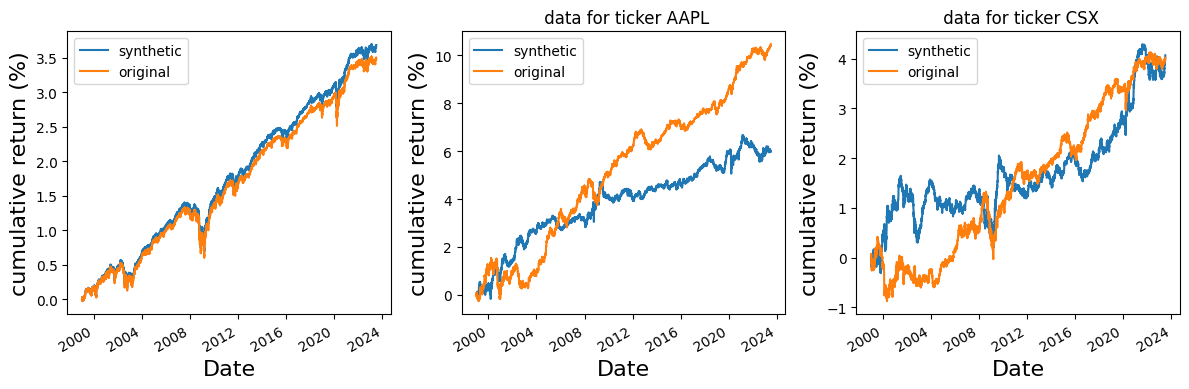

In [136]:
fig,axes = plt.subplots(nrows=1,ncols=3,sharey=False,figsize = (12,4))
cmpr.groupby(level=0).mean().cumsum().plot(ax = axes[0])
axes[0].set_ylabel('cumulative return (%)',fontsize =16)
axes[0].set_xlabel('Date',fontsize =16)


ticker = 'AAPL'
cmpr.xs(ticker,level=1).cumsum().plot(ax = axes[1])
axes[1].set_title(f' data for ticker {ticker}')
axes[1].set_ylabel('cumulative return (%)',fontsize =16)
axes[1].set_xlabel('Date',fontsize =16)

ticker = 'CSX'
cmpr.xs(ticker,level=1).cumsum().plot(ax = axes[2])
axes[2].set_title(f' data for ticker {ticker}')
axes[2].set_ylabel('cumulative return (%)',fontsize =16)
axes[2].set_xlabel('Date',fontsize =16)

fig.tight_layout()
fig.savefig('results/DDPM/cmpr_sample.png')

In [42]:
from evaluation_metrics import eigen_decomposition
from plot_results import plot_eigenvalues

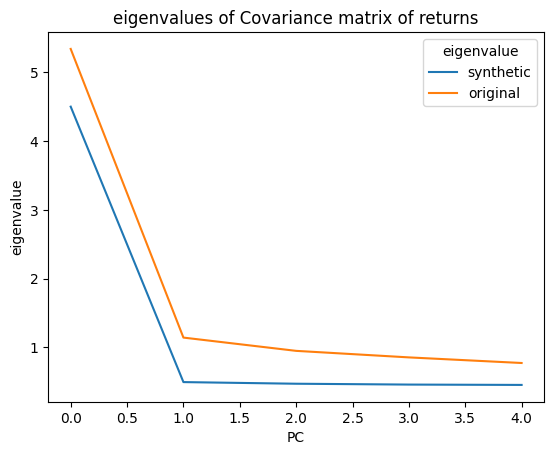

In [135]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def newey_west_cov(df, max_lag=1):
    """
    Compute the Newey-West adjusted covariance matrix for a dataframe of returns.
    
    Parameters:
    - df: Pandas DataFrame where the index is time and columns are different tickers/variables.
    - max_lag: Maximum lag to be considered in the autocorrelation adjustment.
    
    Returns:
    - nw_cov_matrix: Newey-West adjusted covariance matrix as a Pandas DataFrame.
    """
    df = df.dropna()
    
    T, N = df.shape
    
    cov_matrix = df.cov().values
    
    adj_matrix = np.zeros((N, N))
    
    for lag in range(1, max_lag + 1):
        weight = 1 - lag / (max_lag + 1)
        
        cov_lag = df.shift(lag).cov().values
        cov_lag_t = df.shift(-lag).cov().values
        
        adj_matrix += weight * (cov_lag + cov_lag_t)
    
    nw_cov_matrix = cov_matrix + adj_matrix
    
    return pd.DataFrame(nw_cov_matrix, index=df.columns, columns=df.columns) *252

keys = cmpr.columns.tolist()
cov_matrix = []
eigenvalues = []
for key in keys:
    returns = cmpr[key].unstack()
    cov = newey_west_cov(returns)
    cov_matrix.append(cov)
    eigval, eigvec = eigen_decomposition(cov)
    eigenvalues.append(pd.Series(eigval).head(5))
    
eigenvalues = pd.concat(eigenvalues,axis=1,keys=keys)
eigenvalues.index.names = ['PC']
eigenvalues.columns.name = 'eigenvalue'
eigenvalues.plot(ylabel='eigenvalue')
plt.title('eigenvalues of Covariance matrix of returns')
plt.savefig('results/DDPM/pca_eigenvals.png')

Text(0.5, 1.0, 'eigenvalues of Covariance matrix of returns')

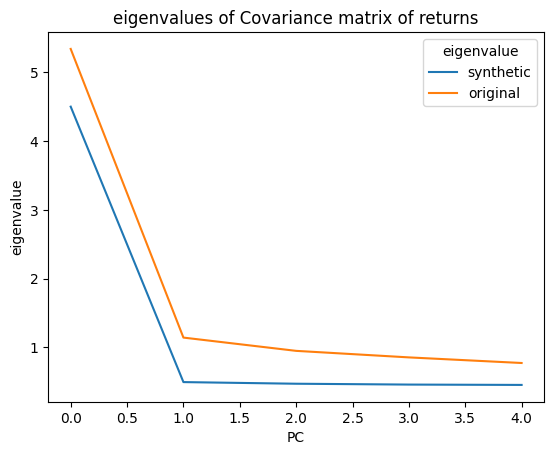

In [46]:
eigenvalues.plot(ylabel='eigenvalue')
plt.title('eigenvalues of Covariance matrix of returns')

In [49]:
def better_sinewave(close, length=None, bars=None, offset=None, **kwargs):
    # Validate arguments
    length = int(length) if length and length > 38 else 40
    bars = int(bars) if bars and bars > 0 else 10
    offset = int(offset) if offset else 0

    if close is None: return

    # variables
    alpha1 = HP = 0 # alpha and HighPass
    a1 = b1 = c1 = c2 = c3 = 0
    Filt = Pwr = Wave = 0

    lastClose = lastHP = 0
    FilterHist = [0, 0]   # Filter history

    # Calculate Result
    m = close.size
    result = [np.nan for _ in range(0, length - 1)] + [0]
    for i in range(length, m):
        # HighPass filter cyclic components whose periods are shorter than Duration input
        alpha1 = (1 - np.sin(360 / length)) / np.cos(360 / length)
        HP = 0.5 * (1 + alpha1) * (close[i] - lastClose) + alpha1 * lastHP

        # Smooth with a Super Smoother Filter from equation 3-3
        a1 = np.exp(-np.sqrt(2) * np.pi / bars)
        b1 = 2 * a1 * np.cos(np.sqrt(2) * 180 / bars)
        c2 = b1
        c3 = -1 * a1 * a1
        c1 = 1 - c2 - c3
        Filt = c1 * (HP + lastHP) / 2 + c2 * FilterHist[1] + c3 * FilterHist[0]
        # Filt = float("{:.8f}".format(float(Filt))) # to fix for small scientific notations, the big ones fail

        # 3 Bar average of Wave amplitude and power
        Wave = (Filt + FilterHist[1] + FilterHist[0]) / 3
        Pwr = (Filt * Filt + FilterHist[1] * FilterHist[1] + FilterHist[0] * FilterHist[0]) / 3

        # Normalize the Average Wave to Square Root of the Average Power
        Wave = Wave / np.sqrt(Pwr)

        # update storage, result
        FilterHist.append(Filt)  # append new Filt value
        FilterHist.pop(0)  # remove first element of list (left) -> updating/trim
        lastHP = HP
        lastClose = close[i]
        result.append(Wave)

    ebsw = pd.Series(result, index=close.index)

    # Offset
    if offset != 0:
        ebsw = ebsw.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        ebsw.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        ebsw.fillna(method=kwargs["fill_method"], inplace=True)

    return ebsw

def get_signal(returns):
    results ={}
    for ticker in (returns.columns.tolist()):
        df_ticker = (returns[[ticker]].cumsum().dropna())+1
        df_ticker.columns = ['close']
        try :
            metrics = better_sinewave(df_ticker['close'],bars = 5,length=10)
            results[ticker] = metrics
        except :
            print(ticker, 'not computed')
    results = pd.concat(results,axis=1)
    results = results
    return results


In [130]:
from scipy.stats import norm


keys = cmpr.columns.tolist()
pnls = []
for key in keys:
    returns = cmpr[key].unstack()
    signal =     - returns.rolling(63).mean() / returns.rolling(63).std()
    signal = signal.sub(signal.mean(1),0)
    signal = signal.div(signal.abs().sum(1),0)
    pnl = (signal.shift()* returns).dropna(axis=0,how = 'all').sum(1)
    pnls.append(pnl)
    
all_pnls_mr = pd.concat(pnls,keys = keys,axis=1)


keys = cmpr.columns.tolist()
pnls = []
for key in keys:
    returns = cmpr[key].unstack()
    signal =    get_signal(returns)
    signal = signal.rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
    signal = signal.sub(signal.mean(1),0)
    signal = signal.div(signal.abs().sum(1),0)
    pnl = (signal.shift()* returns).dropna(axis=0,how = 'all').sum(1)
    pnls.append(pnl)
    
all_pnls_momentum = pd.concat(pnls,keys = keys,axis=1)


C:\Users\marti\AppData\Local\Temp\ipykernel_72932\3091999729.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  HP = 0.5 * (1 + alpha1) * (close[i] - lastClose) + alpha1 * lastHP
C:\Users\marti\AppData\Local\Temp\ipykernel_72932\3091999729.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lastClose = close[i]
C:\Users\marti\AppData\Local\Temp\ipykernel_72932\3091999729.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  HP = 0

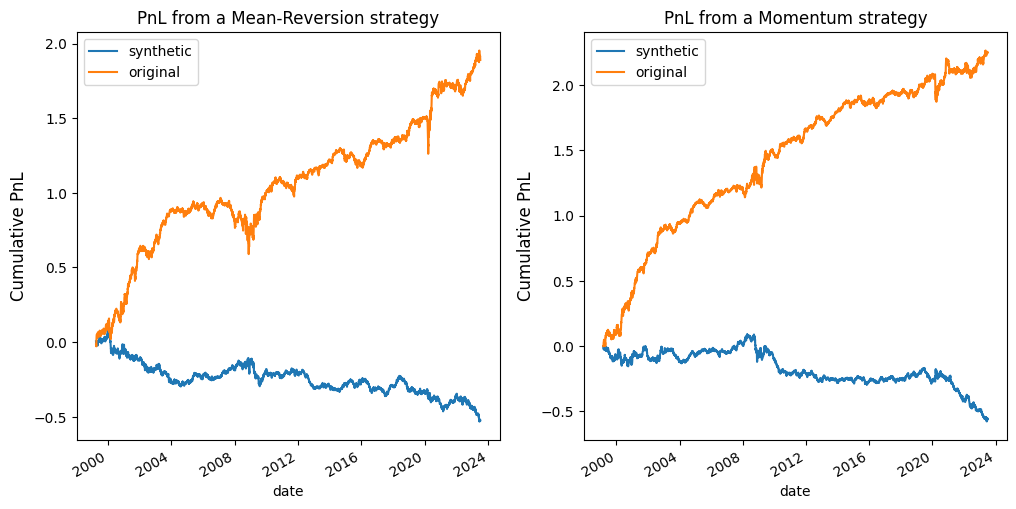

In [134]:
fig,axes = plt.subplots(nrows = 1,ncols= 2,figsize = (12,6))
all_pnls_mr.cumsum().plot(ax = axes[0])
axes[0].set_title('PnL from a Mean-Reversion strategy')
axes[0].set_ylabel('Cumulative PnL',fontsize =12)
all_pnls_momentum.cumsum().plot(ax = axes[1])
axes[1].set_title('PnL from a Momentum strategy')
axes[1].set_ylabel('Cumulative PnL',fontsize =12)
fig.savefig('results/DDPM/cmpr_pnls.png')

Text(0.5, 0.98, 'Wasserstein distance : synthetic vs original data ')

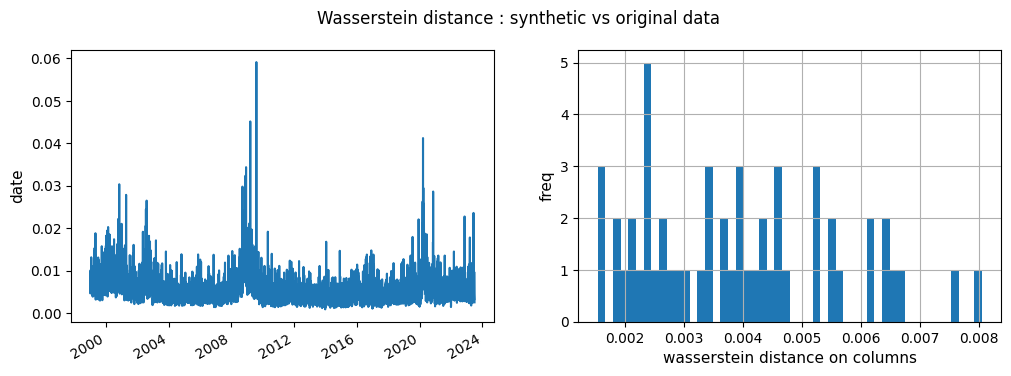

In [141]:
from evaluation_metrics import * 

fig,axes = plt.subplots(nrows=1,ncols = 2,figsize = (12,4))
wass_rows = wasserstein_distance_rows(cmpr['synthetic'].unstack(),cmpr['original'].unstack())
wass_rows.plot(ax= axes[0],legend=False)
axes[0].set_ylabel('Wassertein distance rows',fontsize = 14)
axes[0].set_ylabel('date',fontsize =11)
wass_cols = wasserstein_distance_columns(cmpr['synthetic'].unstack(),cmpr['original'].unstack())['Wassertstein distance col']
wass_cols.hist(bins=50,ax = axes[1])
axes[1].set_xlabel('wasserstein distance on columns',fontsize =11)
axes[1].set_ylabel('freq',fontsize =11)

fig.suptitle('Wasserstein distance : synthetic vs original data ')

In [83]:
kl_col = kl_divergence_columns(cmpr['synthetic'].unstack(),cmpr['original'].unstack())
kl_rows = kl_divergence_rows(cmpr['synthetic'].unstack(),cmpr['original'].unstack())
wasserstein_col = wasserstein_distance_columns(cmpr['synthetic'].unstack(),cmpr['original'].unstack())
wasserstein_rows = wasserstein_distance_rows(cmpr['synthetic'].unstack(),cmpr['original'].unstack())

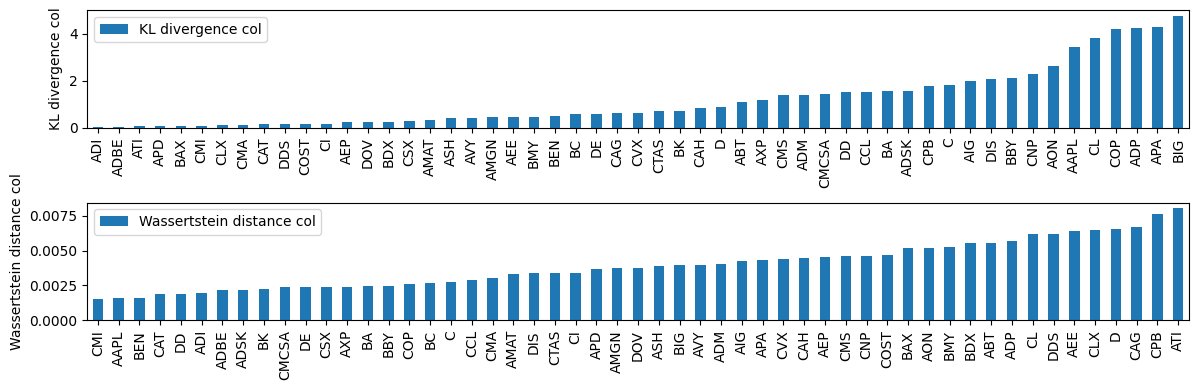

In [142]:
fig,axes = plt.subplots(nrows=2,ncols = 1,figsize = (12,4))
metrics = [kl_col,wasserstein_col]
for i,ax in enumerate(axes):
    to_plot = metrics[i]
    title = to_plot.columns.tolist()[0]
    to_plot = to_plot.sort_values(by = title)
    if 'rows' in title:
        to_plot.plot(ax = axes[i],kind ='line')
    else :
        to_plot.plot(ax = axes[i],kind ='bar')
    axes[i].set_ylabel(title)
    
fig.tight_layout()
fig.savefig('results/DDPM/metrics_cols.png')

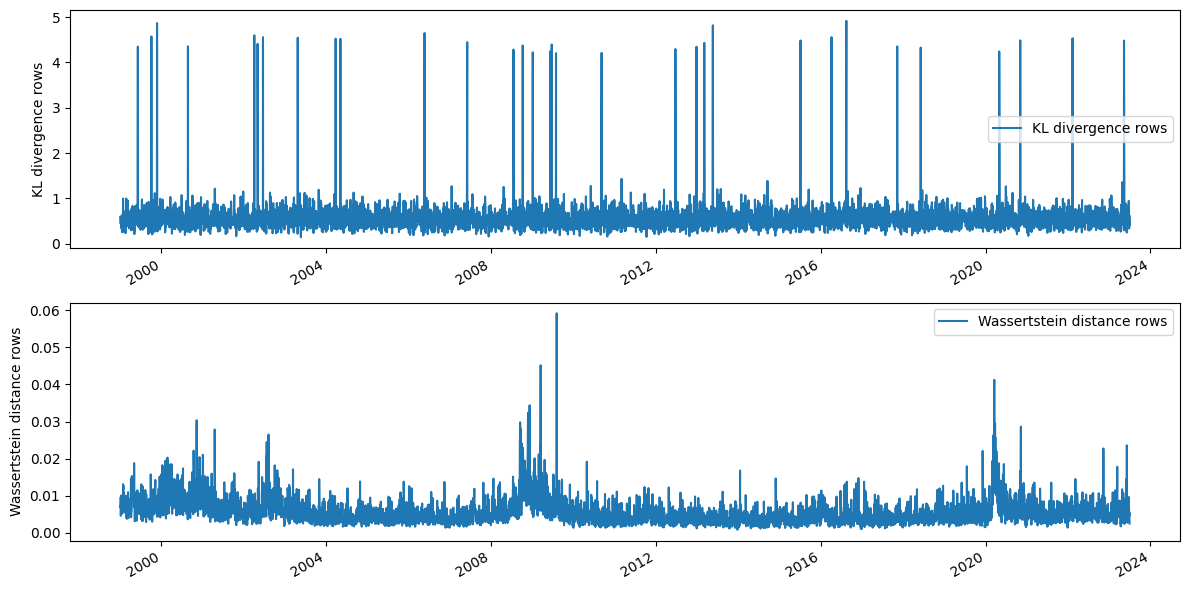

In [138]:
fig,axes = plt.subplots(nrows=2,ncols = 1,figsize = (12,6))
metrics = [kl_rows,wasserstein_rows]
for i,ax in enumerate(axes):
    to_plot = metrics[i]
    title = to_plot.columns.tolist()[0]
    to_plot = to_plot.sort_values(by = title)
    if 'rows' in title:
        to_plot.plot(ax = axes[i],kind ='line')
    else :
        to_plot.plot(ax = axes[i],kind ='bar')
    axes[i].set_ylabel(title)
    
fig.tight_layout()
fig.savefig('results/DDPM/metrics_rows.png')

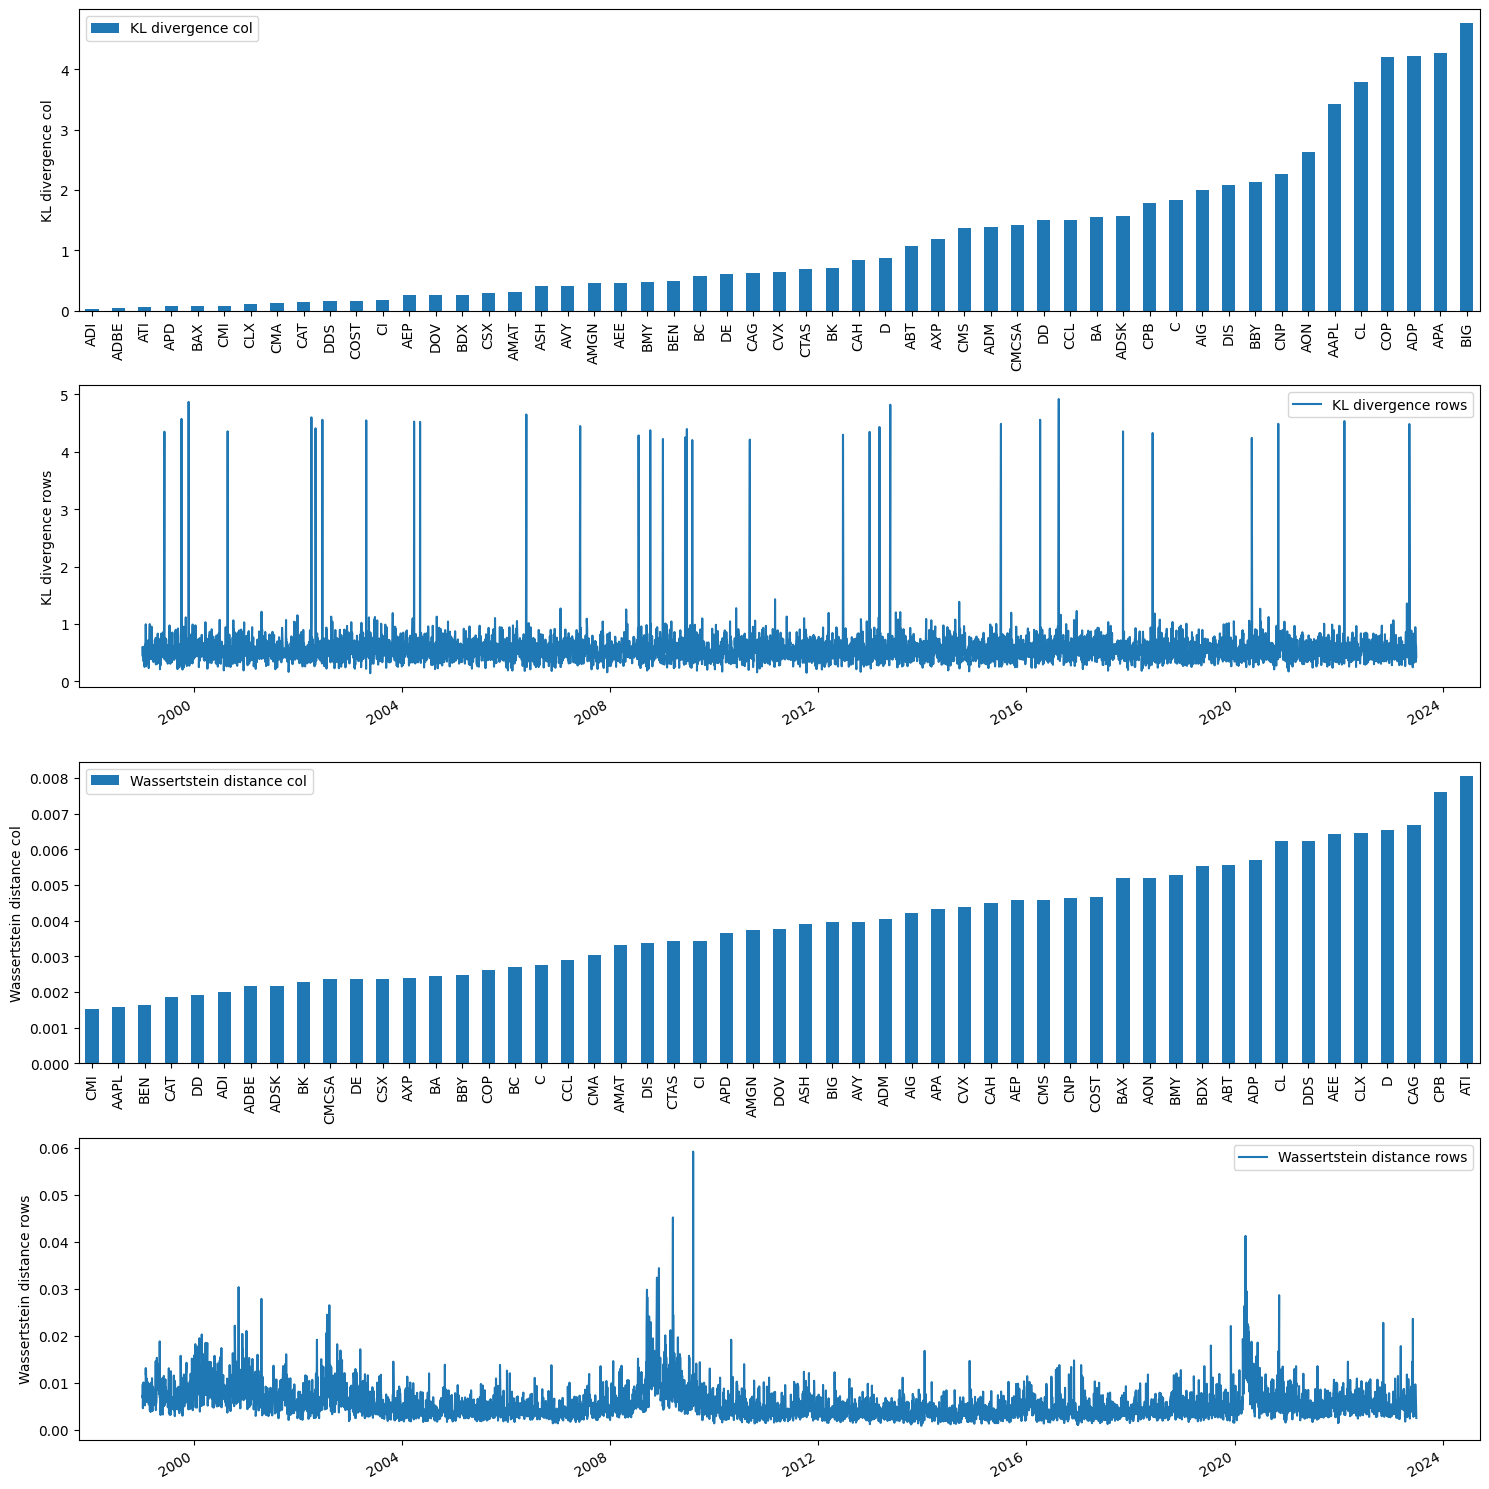

In [85]:
fig,axes = plt.subplots(nrows=4,ncols = 1,figsize = (15,15))
metrics = [kl_col,kl_rows,wasserstein_col, wasserstein_rows]
for i,ax in enumerate(axes):
    to_plot = metrics[i]
    title = to_plot.columns.tolist()[0]
    to_plot = to_plot.sort_values(by = title)
    if 'rows' in title:
        to_plot.plot(ax = axes[i],kind ='line')
    else :
        to_plot.plot(ax = axes[i],kind ='bar')
    axes[i].set_ylabel(title)
    
fig.tight_layout()

In [51]:
def compute_beta(returns: pd.Series, mkt_returns: pd.Series, window=252):
    """
    Calculates the beta of a stock relative to market returns.

    Args:
        returns (pd.Series): Stock return series.
        mkt_returns (pd.Series): Market return series.
        window (int, optional): Rolling window for calculation. Defaults to 252.

    Returns:
        pd.Series: Beta values.
    """
    beta = returns.join(mkt_returns,lsuffix = '_')
    beta.columns = ["stock", "mkt"]
    df_cov = beta.rolling(window).corr().unstack()["stock"]["mkt"]
    df_var = beta["mkt"].to_frame().rolling(window).var()
    return df_cov


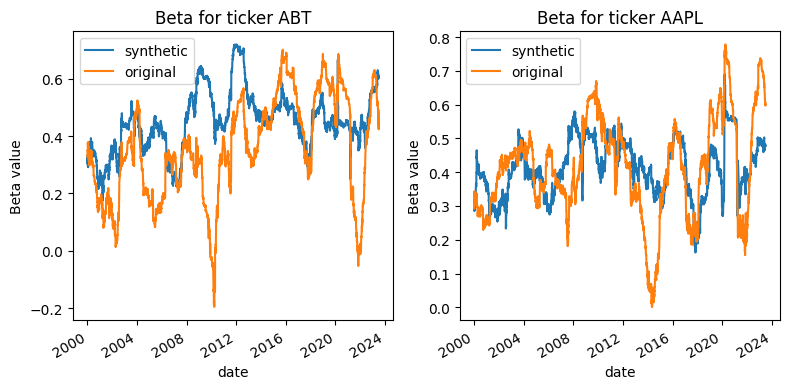

In [139]:
fig, axes = plt.subplots(nrows=1,ncols =2,figsize = (8,4))

keys = cmpr.columns.tolist()
betas = []
for key in keys:
    ticker = 'ABT'
    return_ticker =cmpr.xs(ticker,axis=0,level=1)
    return_mkt = cmpr.groupby(level=0).sum()
    beta = compute_beta(return_ticker[[key]],return_mkt[[key]])
    betas.append(beta)
    
all_betas = pd.concat(betas,keys = keys,axis=1)
all_betas.plot(ax = axes[0])
axes[0].set_title(f'Beta for ticker {ticker}')
axes[0].set_ylabel('Beta value')


keys = cmpr.columns.tolist()
betas = []
for key in keys:
    ticker = 'AAPL'
    return_ticker =cmpr.xs(ticker,axis=0,level=1)
    return_mkt = cmpr.groupby(level=0).sum()
    beta = compute_beta(return_ticker[[key]],return_mkt[[key]])
    betas.append(beta)
    
all_betas = pd.concat(betas,keys = keys,axis=1)
all_betas.plot(ax = axes[1])
axes[1].set_title(f'Beta for ticker {ticker}')
axes[1].set_ylabel('Beta value')

fig.tight_layout()
fig.savefig('results/DDPM/beta.png')

Text(0, 0.5, 'Beta value')

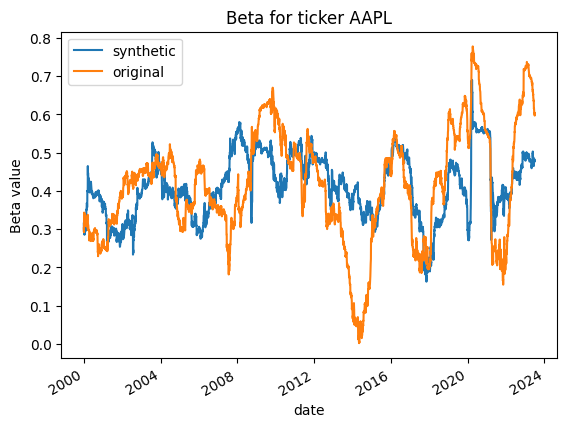

In [53]:
keys = cmpr.columns.tolist()
betas = []
for key in keys:
    ticker = 'AAPL'
    return_ticker =cmpr.xs(ticker,axis=0,level=1)
    return_mkt = cmpr.groupby(level=0).sum()
    beta = compute_beta(return_ticker[[key]],return_mkt[[key]])
    betas.append(beta)
    
all_betas = pd.concat(betas,keys = keys,axis=1)
all_betas.plot()
plt.title(f'Beta for ticker {ticker}')
plt.ylabel('Beta value')

In [97]:
n_feat = len(original_data.columns.tolist())
# evaluation
from evaluation_metrics import TransformerModel
from evaluation_metrics import evaluate_synthetic_data

X_synthetic =  torch.tensor(X_train, dtype=torch.float32, device=DEVICE)
X_synthetic = torch.tensor(X_synthetic, dtype=torch.float32, device=DEVICE)
n_samples = 1000
seq_len = 252
samples_orig = torch.zeros((n_samples, seq_len, n_feat))
samples_synthetic = torch.zeros((n_samples, seq_len, n_feat))
for i in range(n_samples):
    idx = np.random.randint(0, X_train.shape[0]-seq_len)
    samples_orig[i] = X_train[idx:idx+seq_len]
    samples_synthetic[i] = X_synthetic[idx:idx+seq_len]


start = samples_orig[:, 0, :]
samples_orig = samples_orig.cpu().detach().numpy()
gen_samples = samples_synthetic.cpu().detach().numpy()


In [ ]:

eval_model_d = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='classification')
eval_model_p = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='regression')
eval_results = evaluate_synthetic_data(eval_model_d, eval_model_p, gen_samples, samples_orig, train_ratio=0.8)
print(eval_results)
save_dir = 'Results/DDPM/'
np.save(os.path.join(save_dir, 'samples.npy'),samples_synthetic)

In [121]:
eval_results['LPS']

0.88767445